In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## デバイスの設定

In [2]:
if torch.cuda.is_available():    # GPUが使えたら
    device = "cuda:0"
elif torch.backends.mps.is_available():    # Apple Siliconが使えたら
    device = "mps"
else:
    device = "cpu"

print(f"使うデバイス：{device}")

使うデバイス：cuda:0


## データの準備

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),                      # Tensorに変換
    transforms.Normalize((0.1307,), (0.3081,))  # 正規化(平均:0.1307, 標準偏差:0.3081)
])

# データセットの読み込み
train_dataset = torchvision.datasets.MNIST(
    root='./data',          # データの保存先
    train=True,             # 学習用
    download=True,          # ダウンロードする
    transform=transform     # データの前処理
)
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,            # 評価用
    download=True,
    transform=transform
)


# データローダーの作成（ミニバッチの作成）
train_loader = torch.utils.data.DataLoader(
    train_dataset,      # 使うデータセット
    batch_size=64,      # バッチサイズ
    shuffle=True        # シャッフルする
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1000,
    shuffle=False       # シャッフルしない
)


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:02<00:00, 4563459.35it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 58386.13it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1267140.17it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 3263194.38it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## 畳み込みニューラルネットワークの構造定義

In [4]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()  # 親クラスの初期化
        # 畳み込み層の定義
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        # 全結合層の定義
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # 活性化関数の定義
        self.relu = nn.ReLU()
        # プーリング層の定義
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # 特徴抽出部分
        x = self.relu(self.conv1(x))
        x = self.max_pool(x)
        x = self.relu(self.conv2(x))
        x = self.max_pool(x)
        # 一列にする
        x = x.view(-1, 16*5*5)
        # 分類部分
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# シードを固定
torch.manual_seed(42)
np.random.seed(42)

# モデルの生成
model = LeNet5().to(device)
#model = LeNet5()
print(model)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


## モデルの概要

In [5]:
from torchsummary import summary

summary(model, (1, 28, 28))       # (チャネル数, 高さ, 幅)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

## 損失関数と最適化アルゴリズムの定義

In [6]:
# 損失関数
criterion = nn.CrossEntropyLoss()

# 最適化アルゴリズム (Adam, 学習率:0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)

## モデルの学習（訓練）関数の定義

In [7]:
def train(model, train_loader, criterion, optimizer):
    model.train()   # モデルを訓練モードにする
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()               # 勾配を初期化
        outputs = model(inputs)             # 予測
        loss = criterion(outputs, labels)   # 損失を計算
        loss.backward()                     # 勾配を計算
        optimizer.step()                    # パラメータを更新

        running_loss += loss.item()     # 累積誤差

        _, predicted = torch.max(outputs.data, 1)  # 予測結果
        total += labels.size(0)
        correct += (predicted == labels).sum().item()   # 正解数

    avg_loss = running_loss / len(train_loader)     # 平均誤差
    accuracy = correct / total                      # 正解率
    return avg_loss, accuracy

## モデルの検証関数の定義

In [8]:
def test(model, test_loader, criterion):
    model.eval()    # モデルを評価モードにする
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():   # 勾配計算をしない
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)             # 予測
            loss = criterion(outputs, labels)   # 損失を計算

            running_loss += loss.item()     # 累積誤差

            _, predicted = torch.max(outputs.data, 1)       # 予測結果
            total += labels.size(0)
            correct += (predicted == labels).sum().item()   # 正解数

    avg_loss = running_loss / len(test_loader)     # 平均誤差
    accuracy = correct / total                      # 正解率
    return avg_loss, accuracy

## 学習ループ

In [9]:
import time     # 時間計測のため

num_epochs = 10     # エポック数
history = {'train_loss':[], 'train_acc':[], 'test_loss':[], 'test_acc':[]}

for epoch in range(num_epochs):
    start_time = time.time()    # 時間取得
    # 学習
    t_loss, t_accuracy = train(model, train_loader, criterion, optimizer)
    history['train_loss'].append(t_loss)
    history['train_acc'].append(t_accuracy)
    end_train_time = time.time()    # 時間取得

    # 検証
    v_loss, v_accuracy = test(model, test_loader, criterion)
    history['test_loss'].append(v_loss)
    history['test_acc'].append(v_accuracy)

    training_time = end_train_time - start_time     # 学習時間

    # 表示
    print(f"Epoch [{epoch+1}/{num_epochs}] ",
          f"学習Loss:{t_loss:.4f}, 学習精度:{t_accuracy:.4f},",
          f"学習時間:{training_time:.2f}sec",
          f"検証Loss:{v_loss:.4f}, 検証制度:{v_accuracy:.4f}")


Epoch [1/10]  学習Loss:0.2248, 学習精度:0.9308, 学習時間:22.28sec 検証Loss:0.0609, 検証制度:0.9803
Epoch [2/10]  学習Loss:0.0635, 学習精度:0.9801, 学習時間:16.54sec 検証Loss:0.0643, 検証制度:0.9785
Epoch [3/10]  学習Loss:0.0469, 学習精度:0.9854, 学習時間:18.00sec 検証Loss:0.0469, 検証制度:0.9848
Epoch [4/10]  学習Loss:0.0381, 学習精度:0.9877, 学習時間:16.39sec 検証Loss:0.0372, 検証制度:0.9870
Epoch [5/10]  学習Loss:0.0307, 学習精度:0.9902, 学習時間:17.58sec 検証Loss:0.0325, 検証制度:0.9890
Epoch [6/10]  学習Loss:0.0257, 学習精度:0.9916, 学習時間:23.17sec 検証Loss:0.0352, 検証制度:0.9882
Epoch [7/10]  学習Loss:0.0220, 学習精度:0.9926, 学習時間:19.24sec 検証Loss:0.0335, 検証制度:0.9907
Epoch [8/10]  学習Loss:0.0193, 学習精度:0.9937, 学習時間:30.99sec 検証Loss:0.0353, 検証制度:0.9886
Epoch [9/10]  学習Loss:0.0167, 学習精度:0.9946, 学習時間:21.99sec 検証Loss:0.0360, 検証制度:0.9881
Epoch [10/10]  学習Loss:0.0151, 学習精度:0.9946, 学習時間:16.03sec 検証Loss:0.0335, 検証制度:0.9894


## 学習曲線

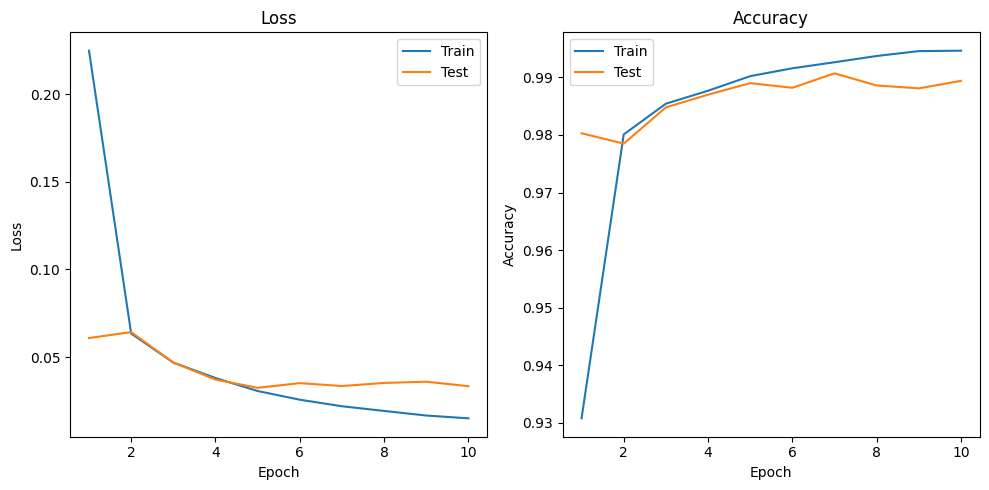

In [10]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), history['train_loss'], label='Train')
plt.plot(range(1, num_epochs+1), history['test_loss'], label='Test')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), history['train_acc'], label='Train')
plt.plot(range(1, num_epochs+1), history['test_acc'], label='Test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## モデルの保存

In [11]:
# モデルの保存
torch.save(model.to('cpu').state_dict(), 'lenet5_mnist.pth')

print("モデル保存")

モデル保存


## モデル性能評価

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix,
                            precision_recall_fscore_support, accuracy_score

def evaluate_model(model, test_loader, device="cpu"):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # 混同行列の計算
    cm = confusion_matrix(all_targets, all_predictions)

    # Precision, Recall, F1スコアの計算
    precision, recall, f1, _ = precision_recall_fscore_support(all_targets,
                                                            all_predictions,
                                                            average='weighted')

    # 正解率（Accuracy）の計算
    accuracy = accuracy_score(all_targets, all_predictions)

    return cm, precision, recall, f1, accuracy

# モデルの評価
cm, precision, recall, f1, accuracy = evaluate_model(model, test_loader)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9894
Precision: 0.9894
Recall: 0.9894
F1 Score: 0.9894


## 混合行列の可視化

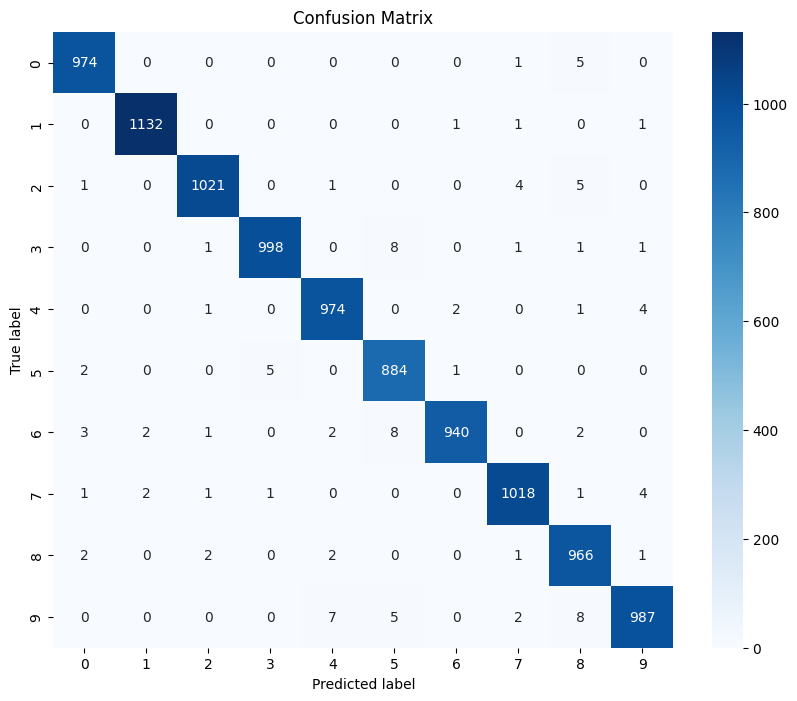

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()